# Cox regression and hazard ratio model

Cox fa analisi di ogni variabile data e predice per ognuna l'hazard ratio, ovvero una probabilità, che se >1 indica che il rischio dell'accadere dell'evento aumenta all'aumentare del valore di quella variabile (o presenza di quella variabile in caso di booleane), mentre diminuisce se l'hazard ratio è <1. 


Input : feature vectors con età del paziente alla diagnosi, last days to follow-up, evento morte booleano, miRNA-seq vector con valori normalizzati con log e quantile.

Pipeline:
   - Scaling con **Z-scaler** su campi di età e miRNA-seq
   - Applicazione di elsatic net tramite ```scikit-survival.CoxnetSurvivalAnalysis``` da addestrare (scikit-survival at: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html)
      - Applicare grid search e K-fold cross validation per capire set di parametri migliori
   - Calcolo di risk score con funzione di predict
        - possibile prevedere survival function o cumulative hazard function anche, ma necessario fare fine tuning con parametro ```fit_baselin_model=True```

Motivazioni:
   - Z-scaler per portare valori predittivi su stessa scala con varianza 1 e media 0
   - Utilizzo di Cox con penalizzazione per fare feature selection e selezionare solo miRNA con maggiore rilevanza
   - Utilizzo Elastic Net poichè Lasso-Cox normale non ottimale per due motivi: non può selezionare più features di quanti sample ci sono e in gruppo di features con alta correlazione tra loro ne sceglie a caso solo una tra queste. Elastic net risolve questi usando combinazione di l1 e l2 e rendendo più robusto

## Init

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json 

In [2]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

d:\Universita\2 anno magistrale\Progetto BioInf\miRNA_to_age


In [96]:
# available datasets:
#   miRNA\\clinical_miRNA_normalized_log.csv
#   miRNA\\clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset_name = 'miRNA\\clinical_miRNA_normalized_log.csv'
dataset = pd.read_csv(os.path.join(DATA_PATH, dataset_name))
dataset_type = dataset_name.split('\\')[-1][9:-4]
subtype=dataset_name.split("\\")[0]
print(subtype, dataset_type)

miRNA miRNA_normalized_log


In [4]:
print(dataset.shape)
print(dataset.columns)
# print(dataset.head())
print(type(dataset.iloc[0]['days_to_death']))

(746, 953)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB', 'pathologic_stage_Stage IIIA',
       'pathologic_stage_Stage IIIC',
       ...
       'hsa-mir-939', 'hsa-mir-940', 'hsa-mir-942', 'hsa-mir-943',
       'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a',
       'hsa-mir-99b'],
      dtype='object', length=953)
<class 'numpy.float64'>


### Hyper-parameters

In [97]:
num_folds = 10
SEED = 42
use_clinical = True
dataset_type = 'clinical_'+dataset_type if use_clinical else 'seq_only'+dataset_type
print(dataset_type)

clinical_miRNA_normalized_log


## Data

In [98]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
if use_clinical:
    print('USING clinical data') 
    X_cols = [col for col in dataset.columns if col not in y_cols]
else:
    print('EXCLUDING clinical data') 
    miRNA_clinical_cols = [col for col in dataset.columns if col not in y_cols and 'hsa' not in col]
    mRNA_clinical_cols = [col for col in dataset.columns if col not in y_cols and 'gene.' not in col]
    X_cols = [col for col in dataset.columns if col not in y_cols and not col in miRNA_clinical_cols and col not in mRNA_clinical_cols]

custom_dtype = np.dtype([
    ('event', np.bool_),         # O 'bool'
    ('time', np.float64)      # O 'float'
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        tuple = (False, row['days_to_last_followup'].item())
        y.append(np.array(tuple, dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]


USING clinical data


## Z-scaling

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

genes_cols = [col for col in X.columns if 'hsa' in col or 'gene.' in col]
genes_cols.append('age_at_initial_pathologic_diagnosis')
scaled_X = pd.DataFrame(scaler.fit_transform(X[genes_cols]), columns=genes_cols)

X[genes_cols] = scaled_X


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_10560\3413578619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[genes_cols] = scaled_X


## Data splitting

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## K-fold

In [77]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Elastic net (Lasso-Cox)

### Setup

In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
import warnings
from sklearn.exceptions import FitFailedWarning

In [104]:
def plot_coefficients(coefs):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    ax.legend(loc='best')

In [105]:
from sksurv.metrics import concordance_index_censored
def c_index_scorer(estimator, X, y):
    # Estrai i campi 'death' e 'days' da y
    event_indicator = y['event']
    event_time = y['time']
    # Predici i punteggi di rischio
    risk_scores = estimator.predict(X)
    # Calcola il concordance index
    c_index = concordance_index_censored(event_indicator, event_time, risk_scores)[0]
    return c_index

### Gridsearch for best paramters

search for already computed best parameters

In [106]:
def parse_array(x):
    if isinstance(x, str):
        x = x.strip('[]')
        return eval(x, {'np':np})
    

bp_path = os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_bp.json")
alphas_path = os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_alphas.csv")
best_params=None

if os.path.exists(bp_path):
    print('Found params')
    with open(bp_path, 'r') as f:
        best_params = json.load(f)
        
if os.path.exists(alphas_path):
    print("found alphas")
    res = pd.read_csv(alphas_path)
    res['param_alphas'] = res['param_alphas'].apply(parse_array)

if best_params:
    print(best_params)
else:
    print("BEst parameters not yet computed")

Found params
found alphas
{'l1_ratio': 0.9, 'alpha_min_ratio': 0.1, 'rcv_best_alpha': [0.01289820551920234], 'filtered_best_alpha': [0.026525318405850176]}


first random search for l1_ratio and alpha_min_ratio

In [ ]:
cen = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.05)

gcv = GridSearchCV(
    cen,
    param_grid={
        "l1_ratio": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "alpha_min_ratio":[0.01, 0.05, 0.1]
    },
    cv=kfold,
    error_score=0.5,
    n_jobs=8,
).fit(X_train, y_train)

print(gcv.best_params_)

# estimated miRNA: 1 min
# estimated mRNA: 10 min

{'alpha_min_ratio': 0.05, 'l1_ratio': 0.4}


TypeError: 'NoneType' object does not support item assignment

In [21]:
best_params={}
best_params['alpha_min_ratio'] = gcv.best_params_['alpha_min_ratio']
best_params['l1_ratio'] = gcv.best_params_['l1_ratio']

then extract estimated alphas

In [22]:
cen = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=best_params['l1_ratio'], alpha_min_ratio = best_params['alpha_min_ratio']))

# warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

cen.fit(X_train, y_train)
estimated_alphas = cen.named_steps["coxnetsurvivalanalysis"].alphas_

and perform another random search for alphas values

In [23]:
cen = CoxnetSurvivalAnalysis(l1_ratio=best_params['l1_ratio'], alpha_min_ratio=best_params['alpha_min_ratio'])

rcv = RandomizedSearchCV(
    cen,
    param_distributions={
        "alphas":[[v] for v in map(float, estimated_alphas)]
    },
    cv=kfold,
    scoring=c_index_scorer,
    error_score=0.5,
    n_iter=30, # 30
    n_jobs=8,
    verbose=2,
    random_state=SEED
).fit(X_train, y_train)

print("\n\n")

res = pd.DataFrame(rcv.cv_results_)
print(rcv.best_params_)

best_params['rcv_best_alpha'] = rcv.best_params_['alphas']

# estimated time for miRNA: 10-15min
# estimated time for mRNA:  140-145 min

Fitting 10 folds for each of 30 candidates, totalling 300 fits



{'alphas': [0.08663213309265702]}


Selection of the best alpha as the one which leaves 20-30 coefficients not 0 and has the highest concordance index

In [24]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


elegible_models = []
min_cols_model = None
for i in range(len(res['param_alphas'])):
    print(f'Testing alpha {i}/{len(res['param_alphas'])}')
    cen = CoxnetSurvivalAnalysis(l1_ratio = best_params['l1_ratio'], alpha_min_ratio = best_params['alpha_min_ratio'], alphas=[res['param_alphas'][i]], max_iter=100000)
    
    try:
        cen.fit(X_train, y_train)
    except Exception as e:
        if isinstance(e, ArithmeticError):
            print("ArithmeticError occurred")
            continue
        else:
            print(e)
            continue

    non0_coefs = len(cen.coef_[cen.coef_ != 0])
    if min_cols_model is None or (non0_coefs > 20 and non0_coefs < min_cols_model['num_coefs']):
        min_cols_model={
            'model':cen,
            'num_coefs':non0_coefs,
            'filtered_best_alpha':res['param_alphas'][i],
            'score':res['mean_test_score'][i]
        }

    if non0_coefs > 20 and non0_coefs <=40:
        elegible_models.append({
            'model':cen,
            'num_coefs':non0_coefs,
            'filtered_best_alpha':res['param_alphas'][i],
            'score':res['mean_test_score'][i]
        })
    
    if len(elegible_models) != 0:
        best_model = elegible_models[0]
        for model in elegible_models:
            if model != best_model and model['score'] > best_model['score']:
                best_model = model
    else:
        best_model = min_cols_model

print(best_model)
best_params['filtered_best_alpha'] = best_model['filtered_best_alpha']

#estimated miRNA: 8-12 min
#estimated mRNA: 120-130 min

Testing alpha 0/30
Testing alpha 1/30
Testing alpha 2/30
Testing alpha 3/30
Testing alpha 4/30
Testing alpha 5/30
Testing alpha 6/30
Testing alpha 7/30
ArithmeticError occurred
Testing alpha 8/30
Testing alpha 9/30
Testing alpha 10/30
Testing alpha 11/30
Testing alpha 12/30
Testing alpha 13/30
Testing alpha 14/30
ArithmeticError occurred
Testing alpha 15/30
Testing alpha 16/30
ArithmeticError occurred
Testing alpha 17/30
ArithmeticError occurred
Testing alpha 18/30
Testing alpha 19/30
Testing alpha 20/30
Testing alpha 21/30
ArithmeticError occurred
Testing alpha 22/30
Testing alpha 23/30
Testing alpha 24/30
Testing alpha 25/30
Testing alpha 26/30
Testing alpha 27/30
ArithmeticError occurred
Testing alpha 28/30
Testing alpha 29/30
{'model': CoxnetSurvivalAnalysis(alpha_min_ratio=0.05, alphas=[[0.0602529621310348]],
                       l1_ratio=0.4), 'num_coefs': 22, 'filtered_best_alpha': [0.0602529621310348], 'score': np.float64(0.4919941056922005)}


In [25]:
print(elegible_models)

[{'model': CoxnetSurvivalAnalysis(alpha_min_ratio=0.05, alphas=[[0.0602529621310348]],
                       l1_ratio=0.4), 'num_coefs': 22, 'filtered_best_alpha': [0.0602529621310348], 'score': np.float64(0.4919941056922005)}, {'model': CoxnetSurvivalAnalysis(alpha_min_ratio=0.05, alphas=[[0.053384051875455474]],
                       l1_ratio=0.4), 'num_coefs': 32, 'filtered_best_alpha': [0.053384051875455474], 'score': np.float64(0.48083905923167647)}]


Saving best parameters into a file

In [26]:
bp_path = os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_bp.json")
alphas_path = os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_alphas.csv")

if best_params['l1_ratio']:
    gcv_best_params = {'l1_ratio':best_params['l1_ratio'], 'alpha_min_ratio':best_params['alpha_min_ratio']}
else:
    gcv_best_params = gcv.best_params_

print(gcv_best_params)

if not os.path.exists(bp_path):
    best_params = gcv_best_params | {'rcv_best_alpha':best_params['rcv_best_alpha'], 'filtered_best_alpha':best_model['filtered_best_alpha']}
    with open(bp_path, 'w') as f:
        json.dump(best_params, f)

if not os.path.exists(alphas_path):
    res.to_csv(alphas_path, index=False)

{'l1_ratio': 0.4, 'alpha_min_ratio': 0.05}


In [85]:
best_params['rcv_best_alpha'], best_params['filtered_best_alpha']

([0.04449831027895047], [0.0981245918698573])

Fitting with new best values found

In [107]:
alphas = [best_params['rcv_best_alpha'], best_params['filtered_best_alpha']]
cv_results_path = os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_cv_results.txt.")
if os.path.exists(cv_results_path):
        with open(cv_results_path, 'w') as f:
            f.write('')
for alpha in alphas:
    msg = ''
    cen_best = CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['alpha_min_ratio'], l1_ratio=best_params['l1_ratio'], alphas=alpha, max_iter=100000)#  #for predicting just the risk score
    cen_best.fit(X_train, y_train)
    msg += f"Finished training cen_best:\n\t{cen_best}\n"

    pred_res = cen_best.predict(X_test)
    c_index = c_index_scorer(cen_best, X_test, y_test)
    msg+=f"Test c-index: {c_index}\n"

    best_vars = X_train.columns[np.where(cen_best.coef_ != 0)[0]]
    msg+=f"Kept {len(best_vars)} variables for infer:\n{best_vars.values}\n"

    msg+="Beginning cross validation on test\n"
    cv = cross_val_score(
         CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['alpha_min_ratio'], l1_ratio=best_params['l1_ratio'], alphas=alpha, max_iter=100000), 
         X, y, cv=kfold, scoring=c_index_scorer)
    msg += f"Cross validation scores: {cv}\n"
    msg += f"Cross validation average: {cv.sum()/len(cv)}\n\n"

    print(msg)

    with open(cv_results_path, 'a') as f:
        f.write(msg)

Finished training cen_best:
	CoxnetSurvivalAnalysis(alpha_min_ratio=0.1, alphas=[0.01289820551920234],
                       l1_ratio=0.9)
Test c-index: 0.4699248120300752
Kept 94 variables for infer:
['age_at_initial_pathologic_diagnosis' 'hsa-mir-1225' 'hsa-mir-1229'
 'hsa-mir-1243' 'hsa-mir-1270' 'hsa-mir-1278' 'hsa-mir-129-2'
 'hsa-mir-1293' 'hsa-mir-1294' 'hsa-mir-135b' 'hsa-mir-1468' 'hsa-mir-187'
 'hsa-mir-18a' 'hsa-mir-3129' 'hsa-mir-3136' 'hsa-mir-3151' 'hsa-mir-3661'
 'hsa-mir-3679' 'hsa-mir-3688-1' 'hsa-mir-3691' 'hsa-mir-376a-1'
 'hsa-mir-3912' 'hsa-mir-3916' 'hsa-mir-3920' 'hsa-mir-4254'
 'hsa-mir-4430' 'hsa-mir-4435-2' 'hsa-mir-4451' 'hsa-mir-4453'
 'hsa-mir-4494' 'hsa-mir-4512' 'hsa-mir-4519' 'hsa-mir-4646'
 'hsa-mir-4651' 'hsa-mir-4653' 'hsa-mir-4660' 'hsa-mir-4713'
 'hsa-mir-4714' 'hsa-mir-4716' 'hsa-mir-4738' 'hsa-mir-4747'
 'hsa-mir-4771-1' 'hsa-mir-4802' 'hsa-mir-488' 'hsa-mir-504'
 'hsa-mir-514a-1' 'hsa-mir-514a-3' 'hsa-mir-5194' 'hsa-mir-519c'
 'hsa-mir-521-1' 'h

Plotting fits for different alphas

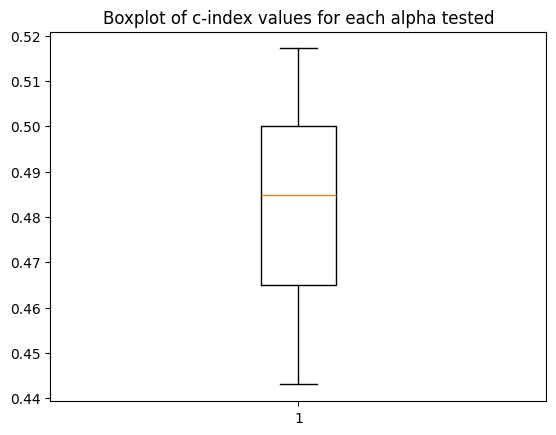

In [108]:
plt.subplot()
plt.boxplot(res['mean_test_score'])
plt.title('Boxplot of c-index values for each alpha tested')
plt.savefig(os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_fit_results.png"))

Plotting different alphas values concnordance-index results

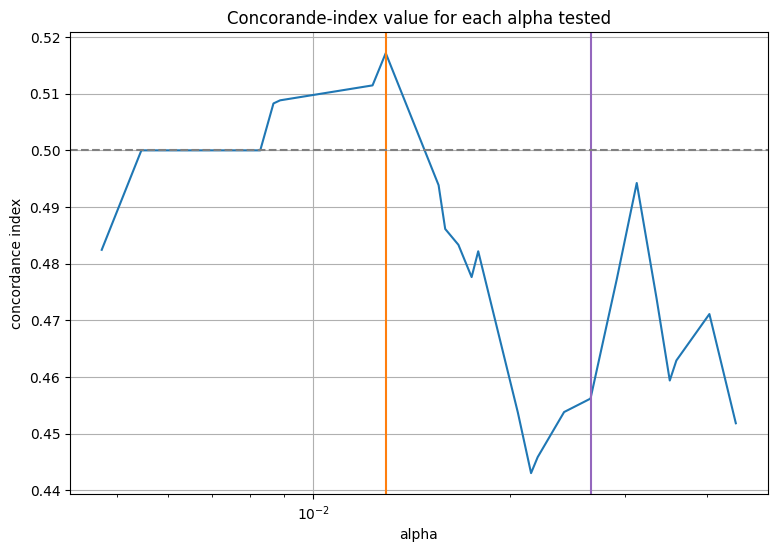

In [109]:
# alphas = res['param_alphas'].sort_values()
alphas = res['param_alphas']#.apply(lambda x: x[0])
mean = res.mean_test_score
std = res.std_test_score

df = pd.DataFrame(data={'alphas':alphas, 'mean':mean, 'std':std})
df = df.sort_values(by='alphas')

alphas = df['alphas']
mean = df['mean']
std=df['std']

fig2, c_alphas_plot = plt.subplots(figsize=(9, 6))
c_alphas_plot.plot(alphas, mean)
c_alphas_plot.set_title('Concorande-index value for each alpha tested')
c_alphas_plot.set_xscale("log")
c_alphas_plot.set_ylabel("concordance index")
c_alphas_plot.set_xlabel("alpha")
c_alphas_plot.axvline(best_params["rcv_best_alpha"][0], c="C1")
c_alphas_plot.axvline(best_params['filtered_best_alpha'][0], c='C4')
c_alphas_plot.axhline(0.5, color="grey", linestyle="--")
c_alphas_plot.grid(True)

plt.savefig(os.path.join(ROOT, f"grid_searches\\{subtype}\\{dataset_type}_alpha_plot.png"))

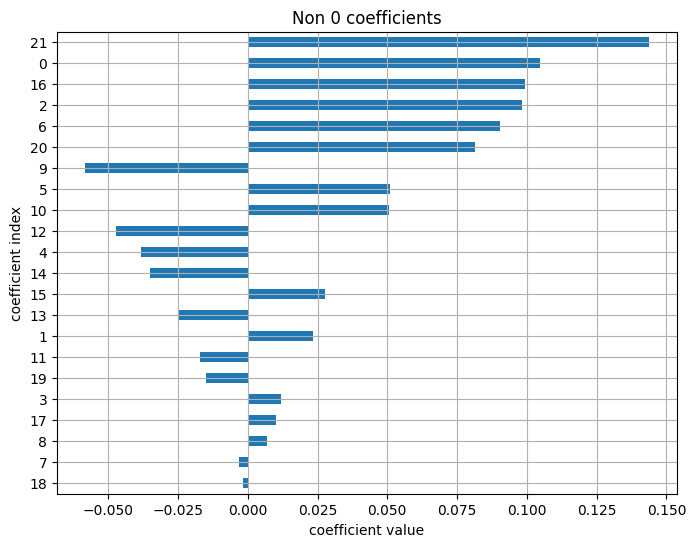

In [110]:
values = cen_best.coef_[cen_best.coef_ != 0]
coefs = X.columns[np.where(cen_best.coef_ != 0)[0]]

df = pd.DataFrame({"coefs":coefs, "values":values})
df = df.sort_values(by='values', key=abs, ascending=True)

fig3, coefs_plot = plt.subplots(figsize=(8, 6))
df.plot.barh(ax=coefs_plot, legend=False)
coefs_plot.set_title('Non 0 coefficients')
coefs_plot.set_xlabel('coefficient value')
coefs_plot.set_ylabel('coefficient index')
coefs_plot.grid(True)
plt.savefig(os.path.join(ROOT, f'grid_searches\\{subtype}\\{dataset_type}_non0_coefs.png'))

In [111]:
X_train['age_at_initial_pathologic_diagnosis']

70     1.745236
164    0.296035
710    1.101146
265   -1.314188
250    0.296035
         ...   
71    -0.348054
106    0.457057
270   -0.831121
435    1.825747
102   -0.589588
Name: age_at_initial_pathologic_diagnosis, Length: 596, dtype: float64

In [ ]:
alphas = [best_params['rcv_best_alpha'], best_params['filtered_best_alpha']]
for alpha in alphas:
    cen_funcs = CoxnetSurvivalAnalysis(l1_ratio=best_params['l1_ratio'], alpha_min_ratio=best_params['alpha_min_ratio'], alphas=alpha, fit_baseline_model=True)
